# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Get the data

In [2]:
dataset= pd.read_excel("Real_estate.xlsx", parse_dates=[0])
dataset.tail()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
409,2013.000000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,2012.666667,5.6,90.45606,9,24.97433,121.54310,50.0
411,2013.250000,18.8,390.96960,7,24.97923,121.53986,40.6
412,2013.000000,8.1,104.81010,5,24.96674,121.54067,52.5
413,2013.500000,6.5,90.45606,9,24.97433,121.54310,63.9


# Clean the data

In [3]:
dataset.isna().sum()

X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

# Split the data into train and test

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [5]:
train_dataset.shape

(331, 7)

In [6]:
test_dataset.shape

(83, 7)

# Inspect the data

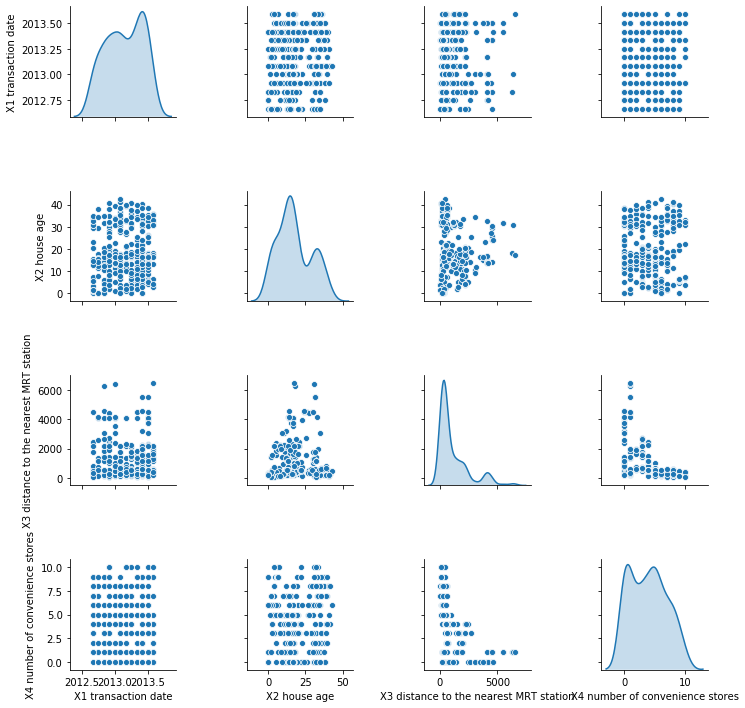

In [7]:
sns.pairplot(train_dataset[['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores']], diag_kind='kde')

In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1 transaction date,331.0,2013.150554,0.278117,2012.666667,2012.916667,2013.166667,2013.416667,2013.583333
X2 house age,331.0,17.652266,11.305017,0.000000,9.950000,16.100000,27.550000,42.700000
X3 distance to the nearest MRT station,331.0,1154.274016,1319.156009,23.382840,289.324800,515.112200,1604.902500,6488.021000
X4 number of convenience stores,331.0,3.996979,2.964945,0.000000,1.000000,4.000000,6.000000,10.000000
X5 latitude,331.0,24.968588,0.012823,24.932070,24.961965,24.970300,24.977450,25.014590
X6 longitude,331.0,121.532759,0.015975,121.473530,121.524620,121.538440,121.543245,121.566270
Y house price of unit area,331.0,37.361329,13.763673,7.600000,26.950000,37.900000,45.500000,117.500000


# Split features from labels

In [9]:
train_d = train_dataset.copy()
test_d = test_dataset.copy()

#split the target from the dataset. This targets are going to be used to predict the model

train_labels = train_dataset.pop('Y house price of unit area') #target 
test_labels = test_dataset.pop('Y house price of unit area') # target

# Normalization

In [10]:
train_d.describe().transpose()[['mean', 'std']]

,mean,std
X1 transaction date,2013.150554,0.278117
X2 house age,17.652266,11.305017
X3 distance to the nearest MRT station,1154.274016,1319.156009
X4 number of convenience stores,3.996979,2.964945
X5 latitude,24.968588,0.012823
X6 longitude,121.532759,0.015975
Y house price of unit area,37.361329,13.763673


In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_d))
print(normalizer.mean.numpy())

[2013.151   17.652 1154.274    3.997   24.969  121.533   37.361]


In [12]:
first = np.array(train_d[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())




First example: [[2012.83   10.3   211.45    1.     24.97  121.53   45.3 ]]

Normalized: [[-1.14 -0.65 -0.72 -1.01  0.44 -0.17  0.58]]


# The model 

In [13]:
def build_nn(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [14]:
model = build_nn(normalizer)

# Inspect the model

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


#  Trial

In [16]:
model.predict(train_d[:10])

array([[-0.033],
       [-0.153],
       [ 0.055],
       [-0.18 ],
       [-0.043],
       [ 0.293],
       [-0.017],
       [-0.176],
       [ 0.228],
       [ 0.047]], dtype=float32)

# Train the model

In [17]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


In [18]:

history = model.fit(
        train_d, train_labels,
        validation_split=0.2,
        verbose=0, epochs=100, callbacks=[PrintDot()])


....................................................................................................

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.856248,1.331288,95
96,0.877228,1.118147,96
97,0.822581,1.154256,97
98,0.841960,1.171047,98
99,0.797888,1.055563,99


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

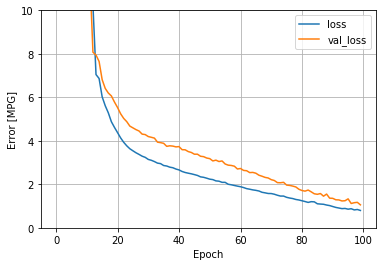

In [21]:
plot_loss(history)

# Predictions

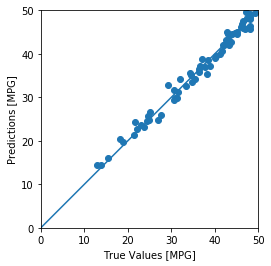

In [22]:
test_predictions = model.predict(test_d).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('')
plt.ylabel('')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [23]:
# error = test_predictions - test_labels
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error [MPG]')
# _ = plt.ylabel('Count')